### Imports

In [1]:
import numpy as np 
import pandas as pd 
import warnings
warnings.filterwarnings(action='ignore')
import plotly.express as px
from plotly.subplots import make_subplots
import plotly.graph_objects as go
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import rcParams
import spacy
nlp = spacy.load('en_core_web_sm')
import nltk
from sklearn.preprocessing import LabelBinarizer
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from wordcloud import WordCloud,STOPWORDS, ImageColorGenerator
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize,sent_tokenize
from bs4 import BeautifulSoup
import re,string,unicodedata
from keras.preprocessing import text, sequence
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score
from sklearn.model_selection import train_test_split
from string import punctuation
from nltk import pos_tag
from nltk.corpus import wordnet
import keras
from keras.models import Sequential
from keras.layers import Dense,Embedding,LSTM,Dropout
from keras.callbacks import ReduceLROnPlateau
import tensorflow as tf
from sklearn.decomposition import LatentDirichletAllocation

# Setting up the enviroment

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import os
os.chdir("/content/drive/MyDrive/IDS566_TextAnalytics")

Reading the data files into Pandas Data Frame

### Readind Data and analysis

In [4]:
real_df = pd.read_csv("/content/drive/MyDrive/IDS566_TextAnalytics/Project/True.csv") #Importing Real News file
fake_df = pd.read_csv("/content/drive/MyDrive/IDS566_TextAnalytics/Project/Fake.csv") #Importing Fake News file

In [5]:
real_df.head(5)

,title,text,subject,date
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,politicsNews,"December 31, 2017"
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,politicsNews,"December 29, 2017"
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,politicsNews,"December 31, 2017"
3,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,politicsNews,"December 30, 2017"
4,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...,politicsNews,"December 29, 2017"


As can be seen from the results below, Real articles are all from PoliticsNews and Worldnews.

In [6]:
real_df.subject.value_counts()

politicsNews    11272
worldnews       10145
Name: subject, dtype: int64

In [7]:
fake_df.head(5)

,title,text,subject,date
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,News,"December 31, 2017"
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,News,"December 31, 2017"
2,Sheriff David Clarke Becomes An Internet Joke...,"On Friday, it was revealed that former Milwauk...",News,"December 30, 2017"
3,Trump Is So Obsessed He Even Has Obama’s Name...,"On Christmas day, Donald Trump announced that ...",News,"December 29, 2017"
4,Pope Francis Just Called Out Donald Trump Dur...,Pope Francis used his annual Christmas Day mes...,News,"December 25, 2017"


Fake articles are from a variety of news sources as can be seen below:

In [8]:
fake_df.subject.value_counts()

News               9050
politics           6841
left-news          4459
Government News    1570
US_News             783
Middle-east         778
Name: subject, dtype: int64

Now we will create a column called 'Class'which will hold 1 for Real news and 0 for fake news. Then Concatinate Real and Fake Dataframes into one.

In [9]:
real_df['class'] = 1 #creating class 1 to categorized real news
fake_df['class'] = 0  #Creating class 0 to categorized false news

fake_news_df = pd.concat([real_df,fake_df])  #concatenating both data frames

In [10]:
fake_news_df.info() #There are no null values in our dataframe. Only the class is an int the other variables are objects. 44898 entries

<class 'pandas.core.frame.DataFrame'>
Int64Index: 44898 entries, 0 to 23480
Data columns (total 5 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   title    44898 non-null  object
 1   text     44898 non-null  object
 2   subject  44898 non-null  object
 3   date     44898 non-null  object
 4   class    44898 non-null  int64 
dtypes: int64(1), object(4)
memory usage: 2.1+ MB


In [11]:
pip install matplotlib==3.1.3

     |████████████████████████████████| 13.1 MB 5.3 MB/s 
  Attempting uninstall: matplotlib
    Found existing installation: matplotlib 3.2.2
    Uninstalling matplotlib-3.2.2:
      Successfully uninstalled matplotlib-3.2.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
albumentations 0.1.12 requires imgaug<0.2.7,>=0.2.5, but you have imgaug 0.2.9 which is incompatible.


We could see from the graph below that the data is balanced

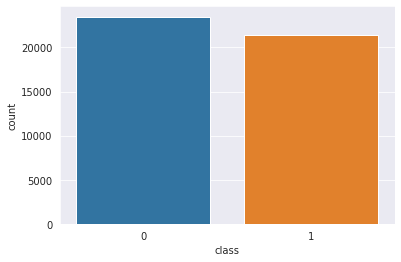

In [12]:
sns.set_style("darkgrid")
sns.countplot( x="class", data = fake_news_df) #the dataset is balanced

Below is the the distribution of the subjects. the majority of subject are PoliticsNews and WorldNews

In [13]:
fake_news_df.subject.value_counts() #Distribution of subject

politicsNews       11272
worldnews          10145
News                9050
politics            6841
left-news           4459
Government News     1570
US_News              783
Middle-east          778
Name: subject, dtype: int64

[Text(0, 0, 'politicsNews'),
 Text(0, 0, 'worldnews'),
 Text(0, 0, 'News'),
 Text(0, 0, 'politics'),
 Text(0, 0, 'Government News'),
 Text(0, 0, 'left-news'),
 Text(0, 0, 'US_News'),
 Text(0, 0, 'Middle-east')]

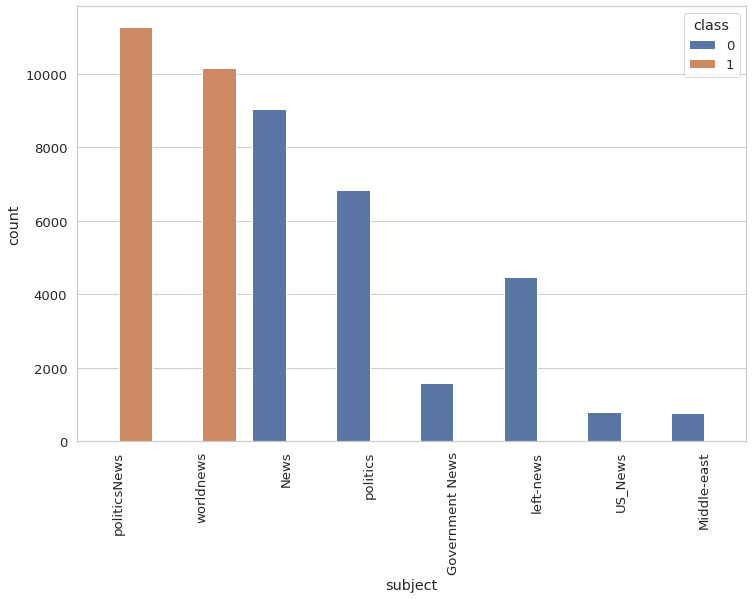

In [14]:
#Distribution of classes per subject
plt.figure(figsize = (12,8))
sns.set(style = "whitegrid",font_scale = 1.2)
chart = sns.countplot(x = "subject", hue = "class" , data = fake_news_df)
chart.set_xticklabels(chart.get_xticklabels(),rotation=90)

Text(0.5, 0.98, 'Average word length in each text')

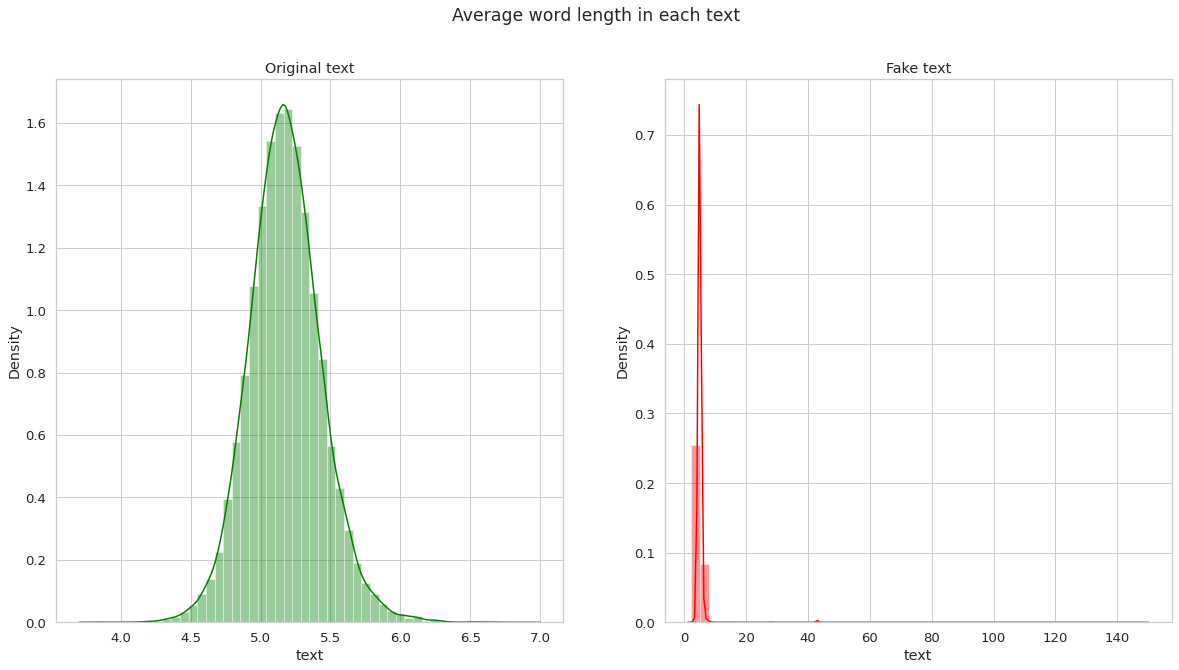

In [15]:
#Average word length in a text
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(20,10))
word=fake_news_df[fake_news_df['class']==1]['text'].str.split().apply(lambda x : [len(i) for i in x])
sns.distplot(word.map(lambda x: np.mean(x)),ax=ax1,color='green')
ax1.set_title('Original text')
word=fake_news_df[fake_news_df['class']==0]['text'].str.split().apply(lambda x : [len(i) for i in x])
sns.distplot(word.map(lambda x: np.mean(x)),ax=ax2,color='red')
ax2.set_title('Fake text')
fig.suptitle('Average word length in each text')

# Data Cleaning

First we merger Subject and the article text into one Columnn called 'text'

In [16]:
#merging the data into 1 column
fake_news_df['text'] = fake_news_df['subject'] + " " + fake_news_df['text'] + " " + fake_news_df['title']

In [17]:
nltk.download("stopwords")
#Dowloading Stop Words
stop = set(stopwords.words('english'))
punctuation = list(string.punctuation)
stop.update(punctuation)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


Creating different functions to clean the data. Clean_text function should be called to do all the cleaning. (Removing stop words, Punctuation, URLs, Noisy Text, etc)

In [18]:
def strip_html(text):
    soup = BeautifulSoup(text, "html.parser")
    return soup.get_text()

#Removing the square brackets
def delete_symbols(text):
    return re.sub('\[[^]]*\]', '', text)
# Removing URL's
def delete_urls(text):
    return re.sub(r'http\S+', '', text)
#Removing the stopwords from text
def delete_stopwords(text):
    final_text = []
    for i in text.split():
        if i.strip().lower() not in stop:
            final_text.append(i.strip())
    return " ".join(final_text)
#Removing the noisy text
def clean_text(text):
    text = strip_html(text)
    text = delete_symbols(text)
    text = delete_urls(text)
    text = delete_stopwords(text)
    return text

Applying Clean Text on all the articles

In [19]:
#Apply cleaning function on text column
fake_news_df['text']=fake_news_df['text'].apply(clean_text)

Word Cloud for Real News shown Below:

<Figure size 1440x1440 with 0 Axes>

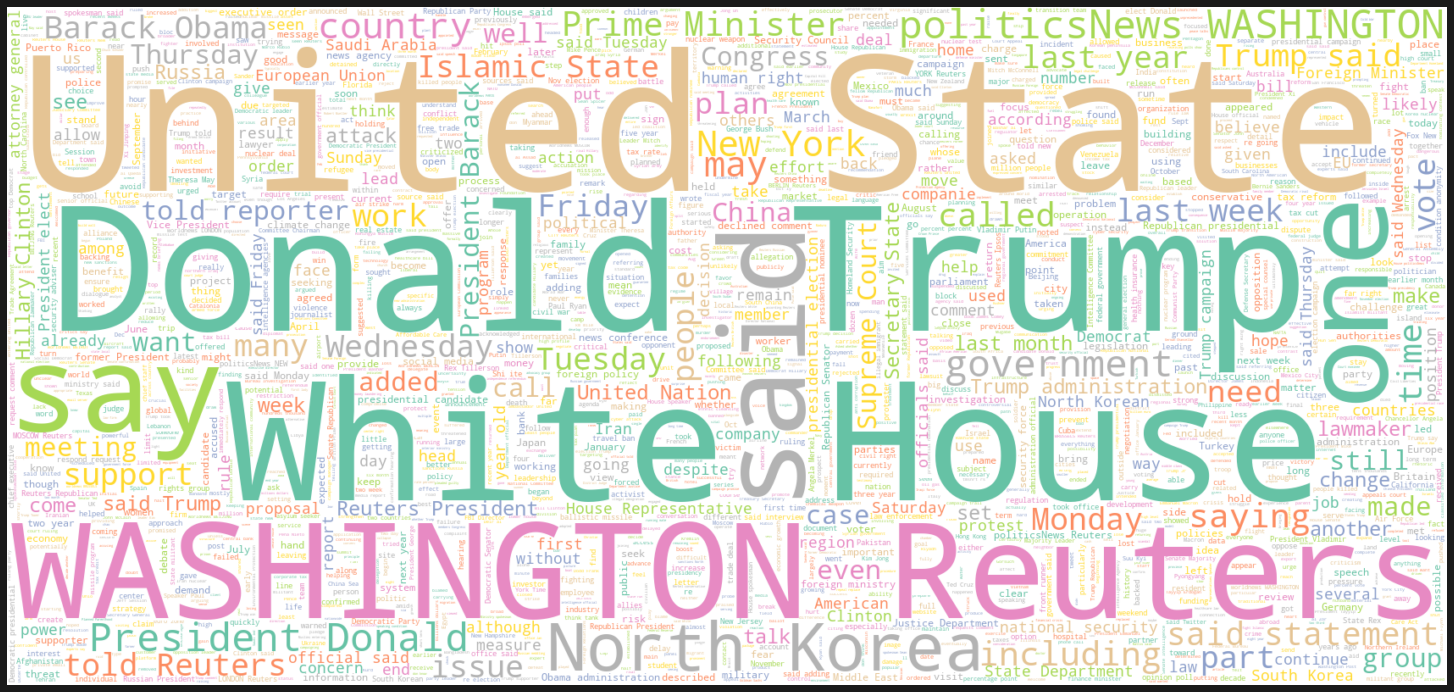

In [20]:
#Wordcloud for real news
plt.figure(figsize = (20,20)) 
wc = WordCloud(background_color='white', colormap= "Set2", max_words = 2000 , width = 1700 , height = 800 , stopwords = STOPWORDS).generate(" ".join(fake_news_df[fake_news_df['class']==1]['text']))
plt.figure(figsize=(20,20), facecolor="k")
plt.imshow(wc , interpolation = 'bilinear')
plt.axis("off")
plt.tight_layout(pad=0)

Wird Cloud for Fake articles shown below:

<Figure size 1440x1440 with 0 Axes>

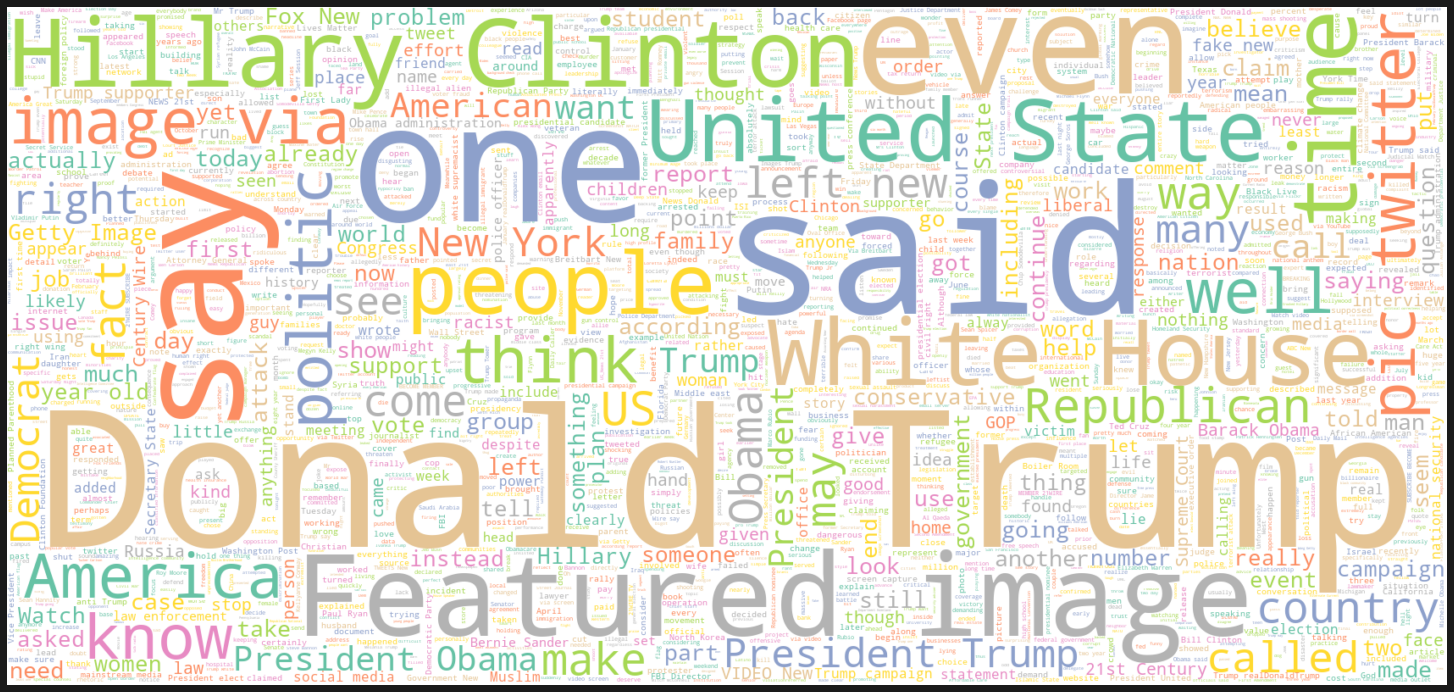

In [21]:
#Wordcloud for real news
plt.figure(figsize = (20,20)) 
wc = WordCloud(background_color='white', colormap= "Set2", max_words = 2000 , width = 1700 , height = 800 , stopwords = STOPWORDS).generate(" ".join(fake_news_df[fake_news_df['class']==0]['text']))
plt.figure(figsize=(20,20), facecolor="k")
plt.imshow(wc , interpolation = 'bilinear')
plt.axis("off")
plt.tight_layout(pad=0)

Get Corpus separates the text into words

In [22]:
def get_corpus(text):
    words = []
    for i in text:
        for j in i.split():
            words.append(j.strip())
    return words
corpus = get_corpus(fake_news_df.text)
corpus[:5]

['politicsNews', 'WASHINGTON', '(Reuters)', 'head', 'conservative']

Printing the most common 10 words

In [23]:
from collections import Counter
counter = Counter(corpus)
most_common = counter.most_common(10)
most_common = dict(most_common)
most_common

{'Donald': 27796,
 'President': 33171,
 'Trump': 111486,
 'U.S.': 50430,
 'also': 30316,
 'one': 29363,
 'people': 33107,
 'said': 93144,
 'said.': 26193,
 'would': 54601}

In [24]:
#CountVectorizer
from sklearn.feature_extraction.text import CountVectorizer
def get_top_text_ngrams(corpus, n, g):
    vec = CountVectorizer(ngram_range=(g, g)).fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]

Printing below a Unigram, Bigram and Trigram

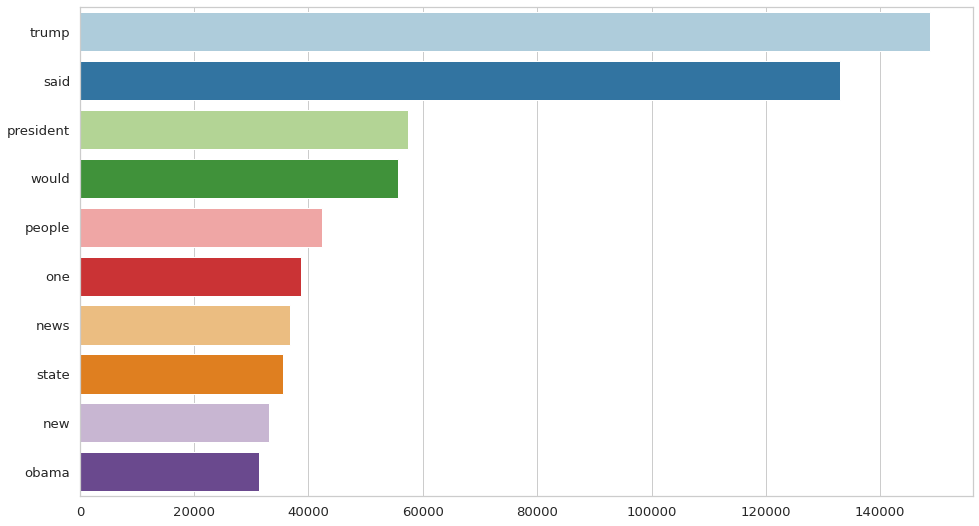

In [25]:
#Unigram Analysis
plt.figure(figsize = (16,9))
unigrams = get_top_text_ngrams(fake_news_df.text,10,1)
unigrams = dict(unigrams)
sns.barplot(x=list(unigrams.values()),y=list(unigrams.keys()), palette="Paired")

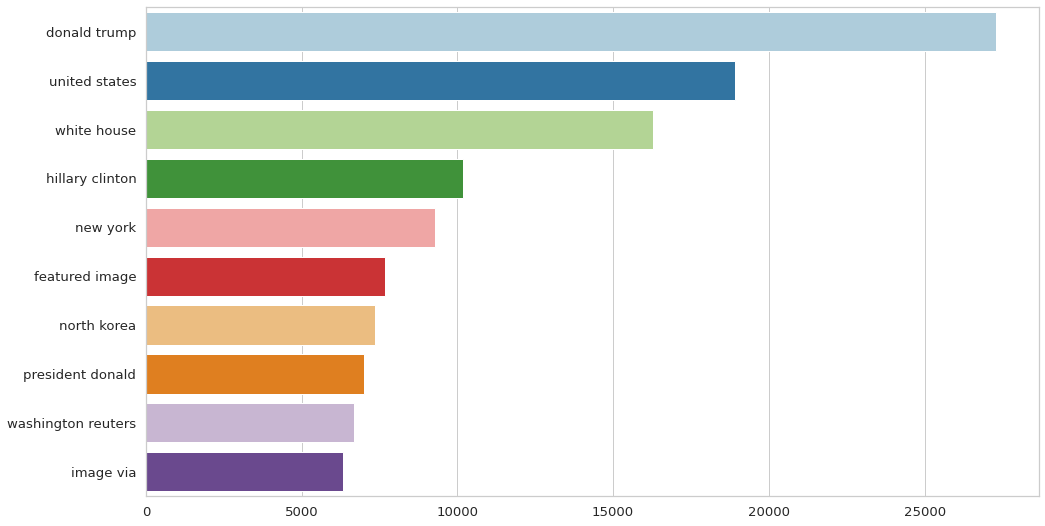

In [26]:
#Bigram Analysis
plt.figure(figsize = (16,9))
bigrams = get_top_text_ngrams(fake_news_df.text,10,2)
bigrams = dict(bigrams)
sns.barplot(x=list(bigrams.values()),y=list(bigrams.keys()), palette="Paired")

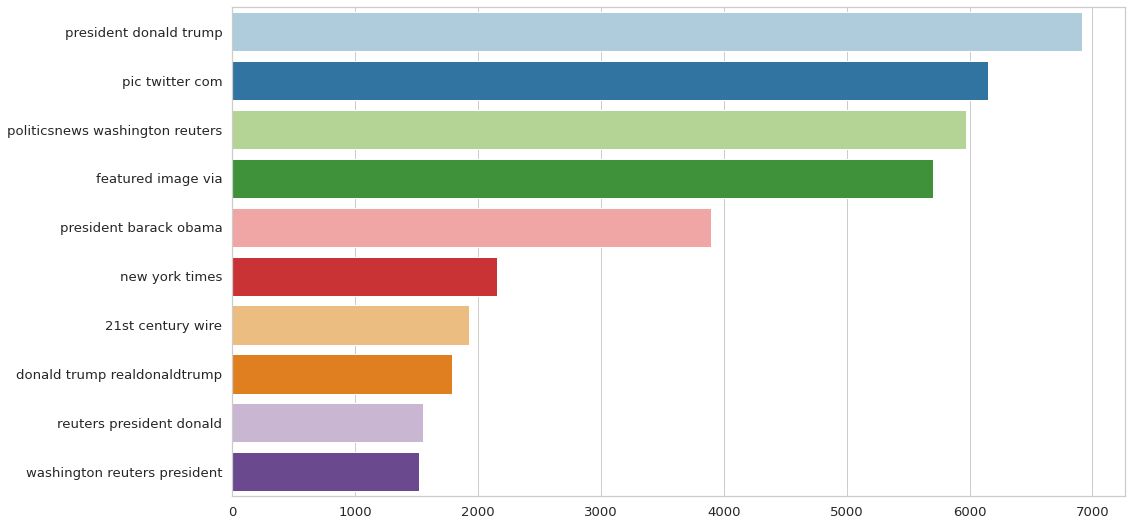

In [27]:
#Trigram Analysis
plt.figure(figsize = (16,9))
trigrams = get_top_text_ngrams(fake_news_df.text,10,3)
trigrams = dict(trigrams)
sns.barplot(x=list(trigrams.values()),y=list(trigrams.keys()), palette = "Paired")

# LDA

Using Bag of Words Transformer in order to run LDA

In [28]:
bow_transformer = CountVectorizer(max_features = 1500).fit(fake_news_df['text'])
bow_df = bow_transformer.transform(fake_news_df['text'])
bow_df.shape

(44898, 1500)

Declaring and fitting the LDA model to transformed BoW. Printing Top 10 words for 10 topics

In [29]:
LDA = LatentDirichletAllocation(
    n_components = 12,
    random_state = 1,
    n_jobs = -1
)
LDA.fit(bow_df)

for index,topic in enumerate(LDA.components_):
    print(f'The top 10 words for topic #{index}')
    print([bow_transformer.get_feature_names()[i] for i in topic.argsort()[-10:]])
    print('\n')

The top 10 words for topic #0
['hillary', 'democratic', 'presidential', 'party', 'campaign', 'election', 'said', 'clinton', 'republican', 'trump']


The top 10 words for topic #1
['get', 'even', 'it', 'obama', 'women', 'would', 'news', 'like', 'one', 'people']


The top 10 words for topic #2
['al', 'government', 'security', 'syria', 'islamic', 'reuters', 'people', 'state', 'military', 'said']


The top 10 words for topic #3
['federal', 'judge', 'rights', 'justice', 'case', 'state', 'law', 'said', 'police', 'court']


The top 10 words for topic #4
['percent', 'house', 'new', 'million', 'tax', 'president', 'obama', 'trump', 'would', 'said']


The top 10 words for topic #5
['january', '2016', 'mexico', 'saudi', '2017', 'trump', 'realdonaldtrump', 'pic', 'com', 'twitter']


The top 10 words for topic #6
['also', 'facebook', 'century', 'political', 'story', 'new', 'the', 'news', 'us', 'media']


The top 10 words for topic #7
['nuclear', 'senate', 'would', 'bill', 'trump', 'house', 'korea', 

# Data Split

Splitting the data into test and train to run LR model

In [30]:
X_train,X_test,y_train,y_test = train_test_split(fake_news_df.text,fake_news_df["class"],random_state = 0)
print(X_train)

13637    worldnews UNITED NATIONS (Reuters) United Stat...
21004    left-news fascinating even facts related Flint...
16499    Government News Pathetic Predictably impotent....
3321     politicsNews WASHINGTON (Reuters) Aides U.S. P...
2345     politicsNews (Reuters) Former FBI Director Jam...
                               ...                        
8986     News Paul Krugman, admission, drooling release...
21243    worldnews GUATEMALA CITY (Reuters) Guatemala t...
21196    left-news PLAN ELECTRICITY RATES WOULD NECESSA...
22150    US_News 21st Century Wire says Washington Russ...
2732     politicsNews WINNIPEG, Manitoba (Reuters) Form...
Name: text, Length: 33673, dtype: object


In [31]:
print(X_test)

13888    politics Democrats want spend whopping $2 bill...
7763     News Republican presidential candidate Texas S...
8388     News National Rifle Association tells us need ...
16820    Government News case live Midwest, might notic...
5099     politicsNews DUBAI (Reuters) Etihad Airways ad...
                               ...                        
2941     politicsNews BEIJING (Reuters) China reacted r...
3251     politicsNews SAN FRANCISCO/WASHINGTON (Reuters...
3490     News debate French television show Niveau Z ro...
9523     politics discovered Austen Fletcher yet, pleas...
19877    worldnews SINGAPORE (Reuters) Hundreds Singapo...
Name: text, Length: 11225, dtype: object


# Modeling

### LR Model using Count Vectorizer

We used Count vectorizer for our first model.

In [32]:
from sklearn.feature_extraction.text import CountVectorizer

  # Fit the CountVectorizer to the training data
vect = CountVectorizer().fit(X_train)
X_train_vectorized = vect.transform(X_train)
X_train_vectorized

<33673x105250 sparse matrix of type '<class 'numpy.int64'>'
	with 5859665 stored elements in Compressed Sparse Row format>

In [33]:
from sklearn.linear_model import LogisticRegression

# Train the model
model = LogisticRegression()
model.fit(X_train_vectorized, y_train)

LogisticRegression()

In [34]:
from sklearn.metrics import roc_auc_score

# Predict the transformed test documents
predictions = model.predict(vect.transform(X_test))

print('AUC: ', roc_auc_score(y_test, predictions))

AUC:  0.9987425844991932


In [35]:
from sklearn import metrics
print(metrics.confusion_matrix(y_test, predictions, labels=[0, 1]))
# Printing the precision and recall, among other metrics
print(metrics.classification_report(y_test, predictions, labels=[0, 1]))

[[5852    6]
 [   8 5359]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      5858
           1       1.00      1.00      1.00      5367

    accuracy                           1.00     11225
   macro avg       1.00      1.00      1.00     11225
weighted avg       1.00      1.00      1.00     11225



Text(0.5, 9.5, 'y_pred')

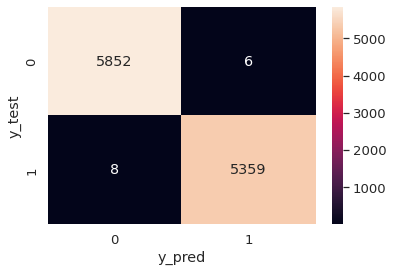

In [36]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, predictions , labels=[0, 1])
ax= plt.subplot()
sns.heatmap(cm, annot=True, fmt='g')
ax.set_ylabel('y_test')
ax.set_xlabel('y_pred')

### LR Model Using TFIDF

In [37]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Fit the TfidfVectorizer to the training data specifiying a minimum document frequency of 5
vect = TfidfVectorizer(min_df=5).fit(X_train)
len(vect.get_feature_names())

X_train_vectorized = vect.transform(X_train)

In [38]:
model = LogisticRegression()
model.fit(X_train_vectorized, y_train)

predictions = model.predict(vect.transform(X_test))

print('AUC: ', roc_auc_score(y_test, predictions))

AUC:  0.9929759764396092


In [39]:
from sklearn import metrics
print(metrics.confusion_matrix(y_test, predictions, labels=[0, 1]))
# Printing the precision and recall, among other metrics
print(metrics.classification_report(y_test, predictions, labels=[0, 1]))

[[5815   43]
 [  36 5331]]
              precision    recall  f1-score   support

           0       0.99      0.99      0.99      5858
           1       0.99      0.99      0.99      5367

    accuracy                           0.99     11225
   macro avg       0.99      0.99      0.99     11225
weighted avg       0.99      0.99      0.99     11225



Text(0.5, 9.5, 'y_pred')

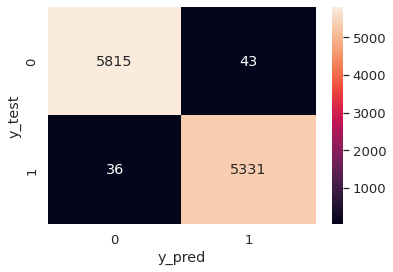

In [40]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, predictions , labels=[0, 1])
ax= plt.subplot()
sns.heatmap(cm, annot=True, fmt='g')
ax.set_ylabel('y_test')
ax.set_xlabel('y_pred')

### LR Using Ngrams

In [41]:
#ngrams
# Fit the CountVectorizer to the training data specifiying a minimum 
# document frequency of 5 and extracting 1-grams and 2-grams
vect = CountVectorizer(min_df=5, ngram_range=(1,3)).fit(X_train)

X_train_vectorized = vect.transform(X_train)

len(vect.get_feature_names())

348718

In [42]:
model = LogisticRegression()
model.fit(X_train_vectorized, y_train)

predictions = model.predict(vect.transform(X_test))

print('AUC: ', roc_auc_score(y_test, predictions))

AUC:  0.9986572311362707


In [43]:
from sklearn import metrics
print(metrics.confusion_matrix(y_test, predictions, labels=[0, 1]))
# Printing the precision and recall, among other metrics
print(metrics.classification_report(y_test, predictions, labels=[0, 1]))

[[5851    7]
 [   8 5359]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      5858
           1       1.00      1.00      1.00      5367

    accuracy                           1.00     11225
   macro avg       1.00      1.00      1.00     11225
weighted avg       1.00      1.00      1.00     11225



Text(0.5, 9.5, 'y_pred')

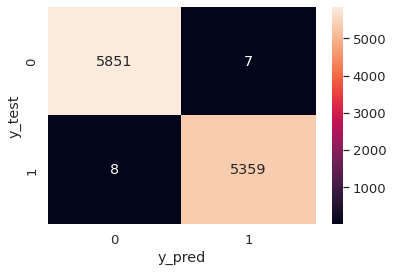

In [44]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, predictions , labels=[0, 1])
ax= plt.subplot()
sns.heatmap(cm, annot=True, fmt='g')
ax.set_ylabel('y_test')
ax.set_xlabel('y_pred')

In [45]:
pip install newspaper3k

     |████████████████████████████████| 211 kB 5.3 MB/s 
     |████████████████████████████████| 7.4 MB 52.6 MB/s 
     |████████████████████████████████| 87 kB 6.6 MB/s 
     |████████████████████████████████| 81 kB 8.6 MB/s 
  Created wheel for tinysegmenter: filename=tinysegmenter-0.3-py3-none-any.whl size=13553 sha256=161f635480f634ff3a90e560ea234096aef8c1cecf2166152a4c4b1fa52931e7
  Stored in directory: /root/.cache/pip/wheels/df/67/41/faca10fa501ca010be41b49d40360c2959e1c4f09bcbfa37fa
  Created wheel for feedfinder2: filename=feedfinder2-0.0.4-py3-none-any.whl size=3357 sha256=c4d3cffa4d69bb790f4e78595550f4475e4a896fd1377c38e6a56efee4fe9148
  Stored in directory: /root/.cache/pip/wheels/7f/d4/8f/6e2ca54744c9d7292d88ddb8d42876bcdab5e6d84a21c10346
  Created wheel for jieba3k: filename=jieba3k-0.35.1-py3-none-any.whl size=7398404 sha256=8bea4647ede6b3d034d775d507badd4faa27e31fcfe310644600012975cd7399
  Stored in directory: /root/.cache/pip/wheels/4c/91/46/3c208287b726df325a597957432

# Main

Main conatins an app that requests the user for an URL and then webscrapes the data from the article and predicts if the article is fake or real using our best LR model

In [47]:
from newspaper import Article
import pandas as pd

def main():
    url = input("Please Enter the Article's URL: ")
    #url = "https://thehill.com/homenews/senate/596402-gop-senators-push-back-hard-on-trumps-praise-of-putin"
    article = Article(url)
    article.download()
    article.parse()
    df = pd.DataFrame(columns = ['text'])
    string = article.text
    df = pd.DataFrame([string], columns=['text'])
    df['text']=df['text'].apply(clean_text)
    predictions = model.predict(vect.transform(df['text']))
    if predictions[0] == 1:
      pred = 'Real News'
    else:
      pred = 'Fake news'

    print(
        f'\033[1mArtile Title: {article.title} \033[0m', 
        f"Model Prediction: {pred}", 
        f"Article text:\n\n {article.text}",  
        sep = '\n\n',
        end = '\n\n\n'
    )
    
if __name__ == "__main__":
    main()

Please Enter the Article's URL: https://thehill.com/homenews/senate/596402-gop-senators-push-back-hard-on-trumps-praise-of-putin
Artile Title: GOP senators push back hard on Trump's praise of Putin 

Model Prediction: Fake news

Article text:

 Russian President Vladimir Putin Vladimir Vladimirovich PutinKennedy Center lights up in blue and yellow to show support for Ukraine Russian opera star ditches Met performances to avoid Putin rebuke DHS grants temporary immigration status to all Ukrainians in the US MORE’s invasion of Ukraine has revealed tensions within the Republican Party over how hard to push back on the aggression and how to respond to former President Trump Donald TrumpMcCarthy-backed Republican wins contested Texas House primary DHS grants temporary immigration status to all Ukrainians in the US Senate GOP shrugs off latest Trump revelation MORE’s glowing praise of Putin.

The national security crisis has shown Trump to be seriously out of step with GOP leaders on charact